This notebook evaluates the probe on the set of test words (all polysemous senses)

In [7]:
from core.analysis import *
from core.metrics import *
from core.semcor_bert_pipeline import get_pos, save_embeds_with_wts, load_data
from scipy.stats import mode
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

## Data Prep

Reading in experimental data to see which words to run the model on

In [8]:
with open('../data/stimuli.json') as f:
    db = json.load(f)
    

In [17]:
results = pd.read_csv('../data/approved_expt_results.csv')
incl_users = results['userID'].unique()

logistic_words = results[(results['trialType'] == 'test') |
                                (results['trialType'] == 'repeat')]['lemma'].unique()

## Modeling

Compute F1 scores through cross validation

In [18]:
def get_senses(db, word):
    """
    Queries FB for the list of senses that were used in the experiment for word (format word_pos) 
    """
    sr_types = {'face_n': ['expression_n_01', 'face_n_04'], 'book_n': ['record_n_05'],
     'glass_n': ['glass_n_03'], 'door_n': ['door_n_03'], 'school_n': ['school_n_03'], 
     'heart_n': ['heart_n_03']}

    if word not in sr_types:
        return [k for k in db['inputs'][word] if k not in ['senses', 'type']]
    else:
        insuf_instances = sr_types[word]
        return [k for k in db['inputs'][word] if k not in ['senses', 'type'] + insuf_instances]


In [19]:

model_data = {}
test_stats = []
incorrect = []
for w in tqdm(logistic_words):
    word, pos = w.split('_')
    word_data = load_data(word, pos, 'semcor')
    true_labels = word_data['sense_labels']
    random_labels = np.random.choice(true_labels, len(true_labels))
    most_common = mode(true_labels)
    maj_labels = [most_common[0][0]] * len(true_labels)
    pca_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w)], use_pca = True,
                               use_masc = False, delim = '_')

    model_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                               use_masc = False, delim = '_')
    model_data[w] = model_results
    test_stats.append({"word": w, 'avg_f1': np.mean(model_results['f1']),
                         'avg_f1_pca': np.mean(pca_results['f1']),
                      'avg_f1_random': f1_score(true_labels, random_labels, average = 'weighted'),
                      'avg_f1_maj': f1_score(true_labels, maj_labels, average = 'weighted')})    
    incorrect.append(misclassified_sentences(model_results, model_results['incorrect_indices']))

100%|██████████| 26/26 [37:31<00:00, 86.60s/it] 


Accuracies and F1 scores for Test Words for 5 fold Cross Validation 

In [20]:
model_perf = pd.DataFrame(test_stats).sort_values('avg_f1', ascending = False)

In [21]:
model_perf

,word,avg_f1,avg_f1_pca,avg_f1_random,avg_f1_maj
8,area_n,0.911541,0.922274,0.618573,0.655229
9,ask_v,0.908008,0.892889,0.443631,0.406448
7,glass_n,0.895385,0.872527,0.407821,0.424561
4,raise_v,0.887805,0.894581,0.195602,0.210181
1,heart_n,0.882020,0.942511,0.351858,0.282594
17,light_n,0.868416,0.793569,0.321068,0.325313
15,school_n,0.868037,0.894600,0.743328,0.781563
25,man_n,0.829910,0.802886,0.591033,0.653590
24,point_n,0.821295,0.803313,0.282313,0.260856
5,book_n,0.808918,0.837444,0.658272,0.701592


In [22]:
model_perf.mean()

word             0.000000
avg_f1           0.742059
avg_f1_pca       0.740367
avg_f1_random    0.393414
avg_f1_maj       0.381470
dtype: float64

## Analysis of Classifier Performance

We plot F1 score with respect to entropy and number of senses

In [23]:
model_perf['Part of Speech'] = model_perf['word'].apply(lambda s: s.split("_")[1])
model_perf['Part of Speech'].replace({"n": "Noun", "v": "Verb"}, inplace = True)
model_perf

,word,avg_f1,avg_f1_pca,avg_f1_random,avg_f1_maj,Part of Speech
8,area_n,0.911541,0.922274,0.618573,0.655229,Noun
9,ask_v,0.908008,0.892889,0.443631,0.406448,Verb
7,glass_n,0.895385,0.872527,0.407821,0.424561,Noun
4,raise_v,0.887805,0.894581,0.195602,0.210181,Verb
1,heart_n,0.882020,0.942511,0.351858,0.282594,Noun
17,light_n,0.868416,0.793569,0.321068,0.325313,Noun
15,school_n,0.868037,0.894600,0.743328,0.781563,Noun
25,man_n,0.829910,0.802886,0.591033,0.653590,Noun
24,point_n,0.821295,0.803313,0.282313,0.260856,Noun
5,book_n,0.808918,0.837444,0.658272,0.701592,Noun


Average F1 score on polysemous items

In [24]:
np.mean(model_perf['avg_f1'])

0.7420588348986841

Adding the data from the homonymous stimuli (copied from `logistic_shared`)

In [25]:
np.mean(list(model_perf['avg_f1']) + [1, 1, 1, 1, 0.962, 0.982])

0.7886728033551808

In [26]:
np.mean(list(model_perf['avg_f1_maj']) + [0.40238556, 0.4109972 , 0.49115646, 0.5444478 , 0.49811676,
       0.65636364])

0.4038030387875106

In [27]:
np.mean(list(model_perf['avg_f1_random']) + [0.48836763, 0.32128302, 0.47631976, 0.46463469, 0.41616162,
       0.62506667])

0.40689363572149156

Reading in the entropy data

In [28]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types_revised.csv')
semcor_entropy['word'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
with_entropy = model_perf.merge(semcor_entropy, on = 'word')

In [29]:
with_entropy.sort_values('entropy')

,word,avg_f1,avg_f1_pca,avg_f1_random,avg_f1_maj,Part of Speech,Lemma,pos,entropy,num_senses,freq
9,way_n,0.725325,0.759890,0.373529,0.390540,Noun,way.n,n,0.728521,3,269
4,man_n,0.829910,0.802886,0.591033,0.653590,Noun,man.n,n,0.765556,3,566
8,begin_v,0.742814,0.775913,0.604938,0.675905,Verb,begin.v,v,0.977502,3,359
0,area_n,0.911541,0.922274,0.618573,0.655229,Noun,area.n,n,1.002968,3,200
1,ask_v,0.908008,0.892889,0.443631,0.406448,Verb,ask.v,v,1.178508,3,408
10,case_n,0.705826,0.650716,0.309207,0.337717,Noun,case.n,n,1.211936,3,127
11,consider_v,0.696630,0.686023,0.266224,0.265460,Verb,consider.v,v,1.394831,3,229
6,put_v,0.749113,0.750578,0.421652,0.342260,Verb,put.v,v,1.402340,3,257
14,world_n,0.618047,0.657313,0.168794,0.131720,Noun,world.n,n,1.403639,3,149
5,point_n,0.821295,0.803313,0.282313,0.260856,Noun,point.n,n,1.413418,3,118


In [30]:
np.mean(with_entropy[with_entropy['entropy'] < 1.5]['avg_f1'])

0.7657957928258937

In [31]:
np.mean(with_entropy[with_entropy['entropy'] > 1.5]['avg_f1'])

0.6359896137402208

In [32]:
from adjustText import adjust_text

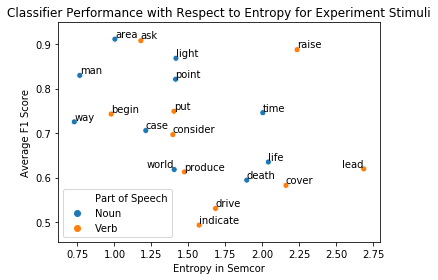

In [33]:
ent_f1 = sns.scatterplot(x = 'entropy', y = 'avg_f1', hue = 'Part of Speech', data = with_entropy)

texts = []
for x, y, s in zip(with_entropy['entropy'], with_entropy['avg_f1'], with_entropy['word'].apply(lambda s: s.split("_")[0])):
    texts.append(plt.text(x, y, s))

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1, 1), expand_text=(1, 1))
plt.xlabel("Entropy in Semcor")
plt.ylabel("Average F1 Score")
plt.title("Classifier Performance with Respect to Entropy for Experiment Stimuli")
plt.tight_layout()
plt.savefig("../../results/figures/f1_entropy_expt.png")

## Confusion Matrices

We plot the results from the experiment with the cosine similarity of the BERT centroids, as well as the confusion matrices for the classification task. 

In [34]:
import seaborn as sns

In [35]:
from matplotlib.backends.backend_pdf import PdfPages

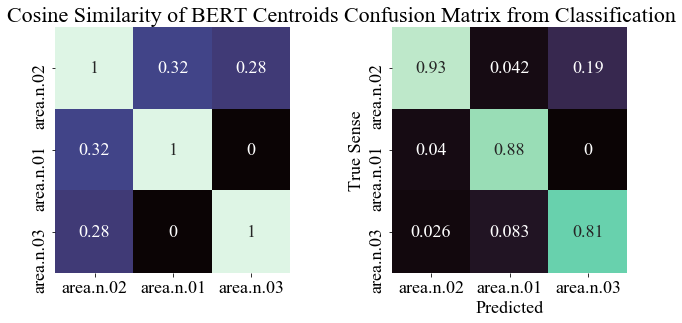

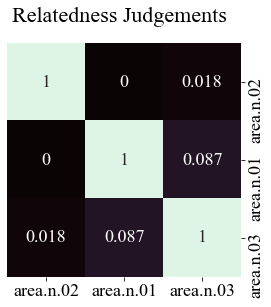

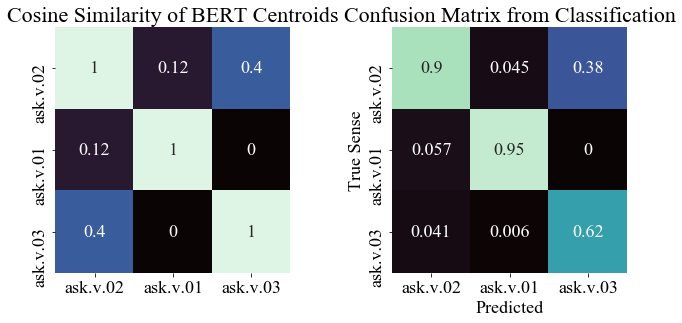

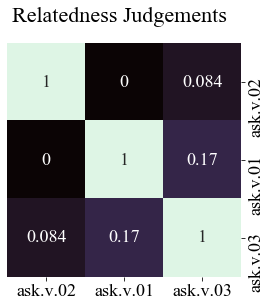

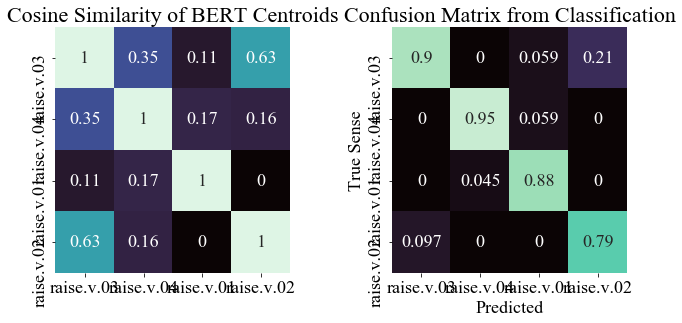

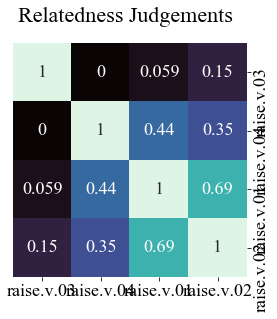

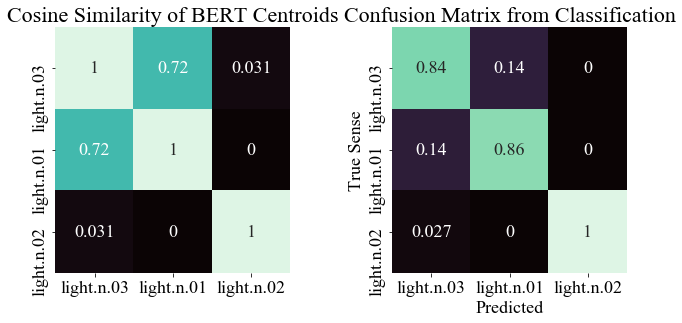

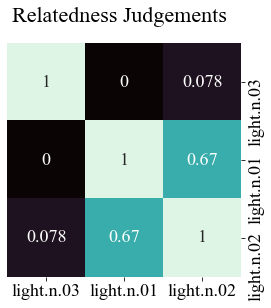

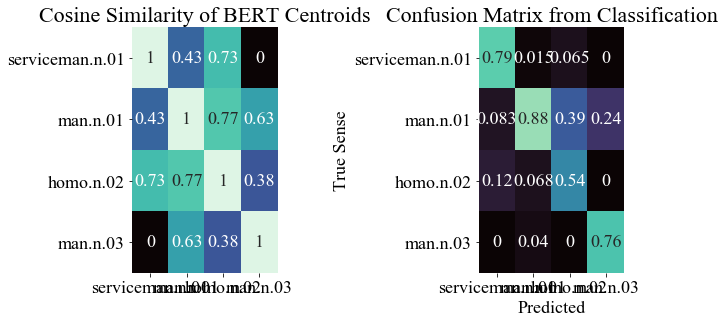

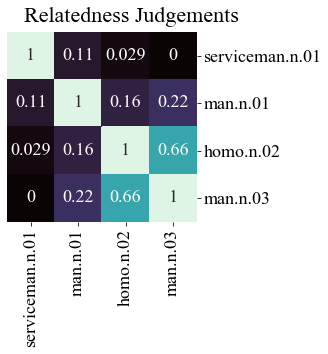

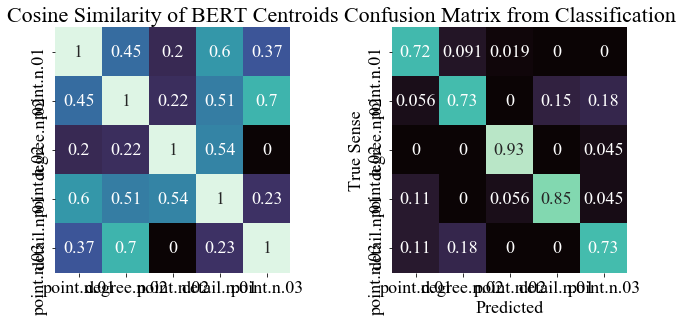

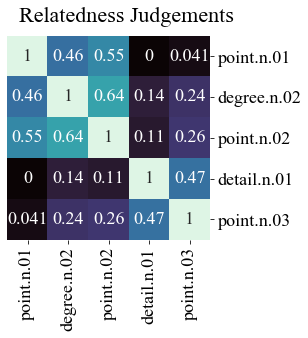

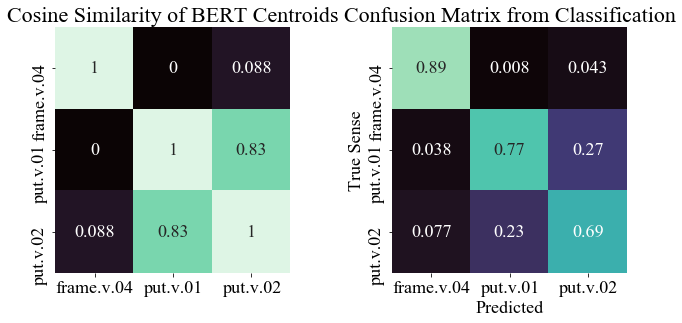

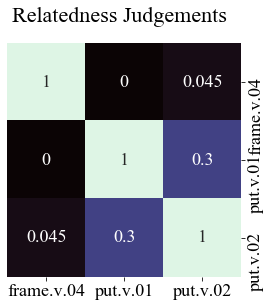

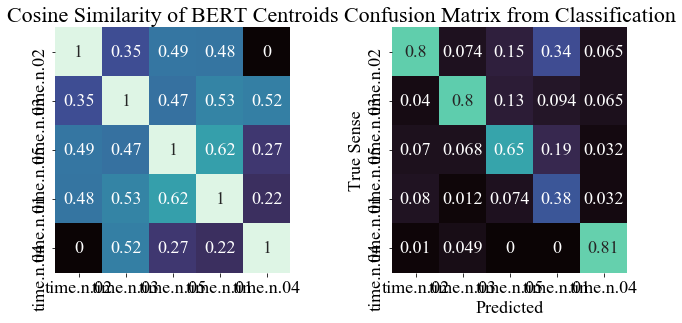

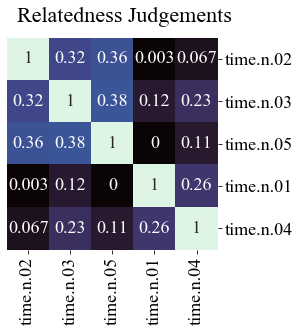

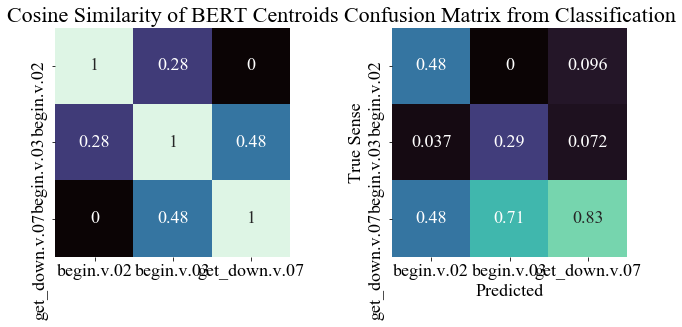

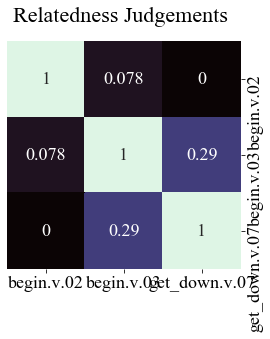

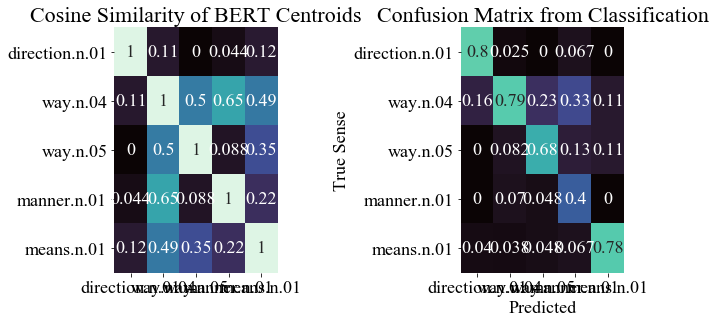

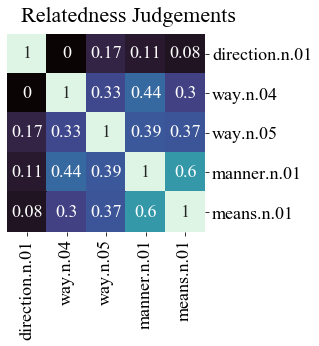

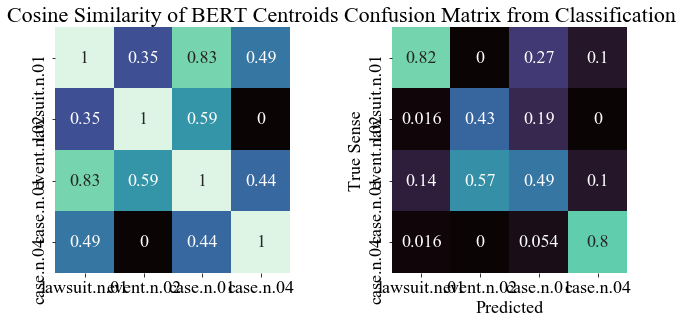

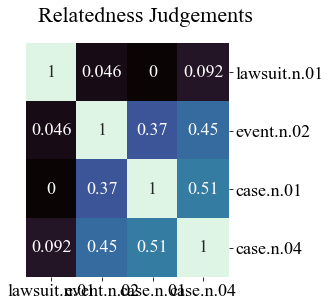

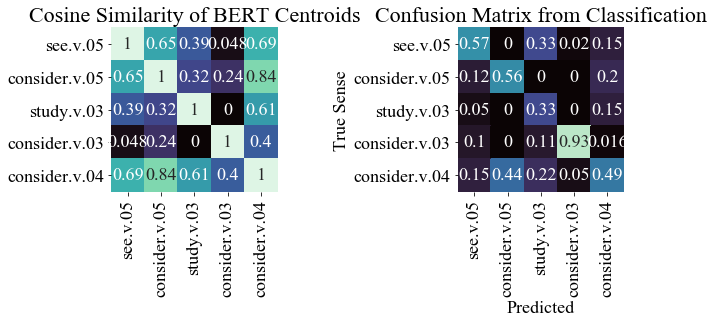

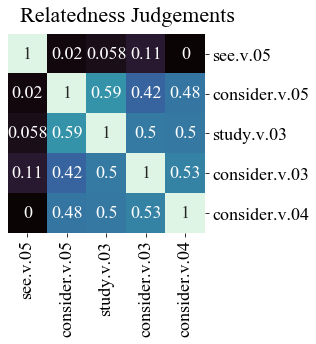

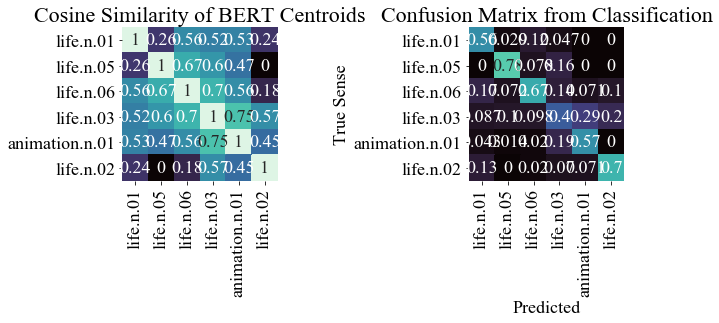

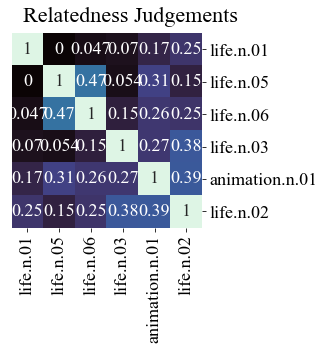

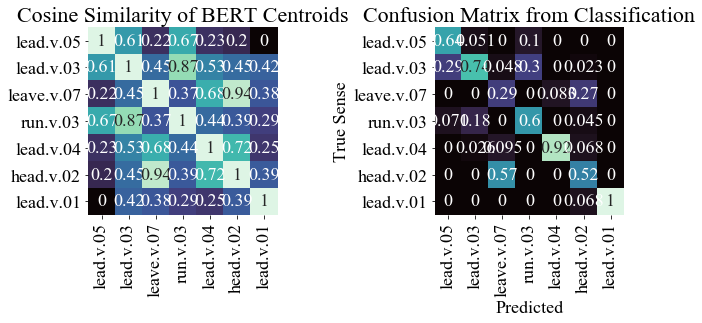

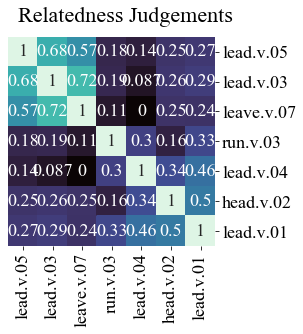

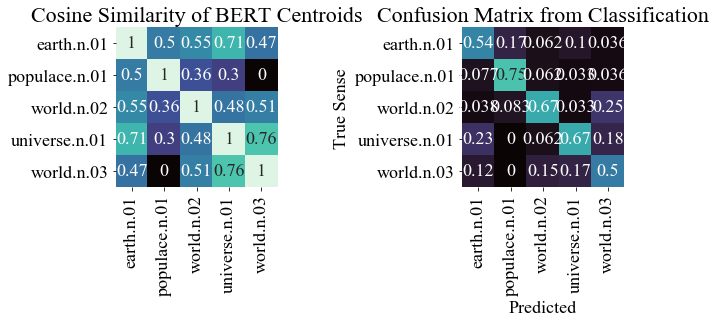

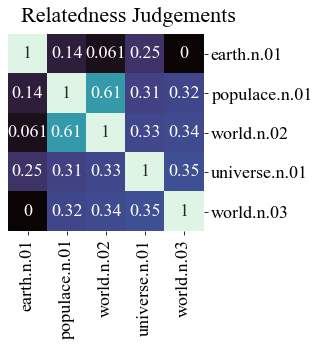

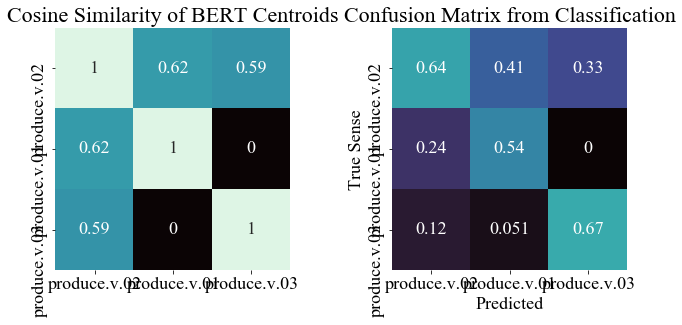

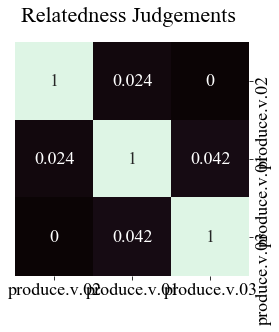

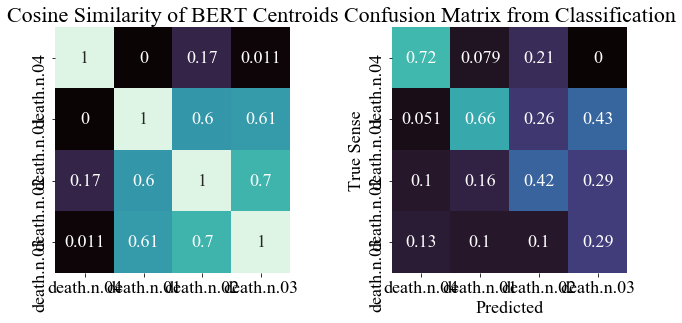

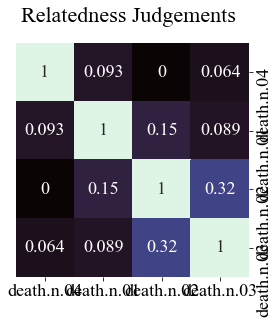

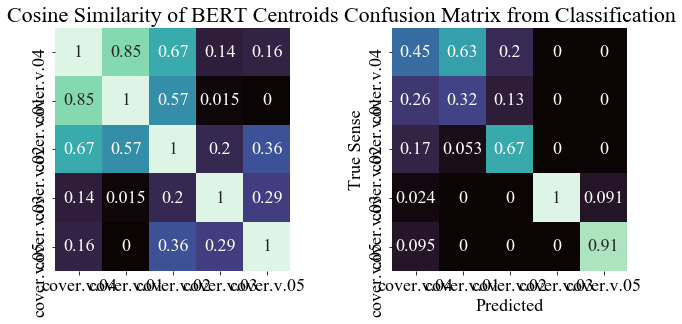

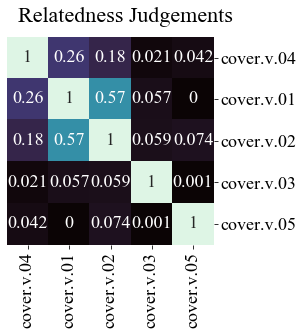

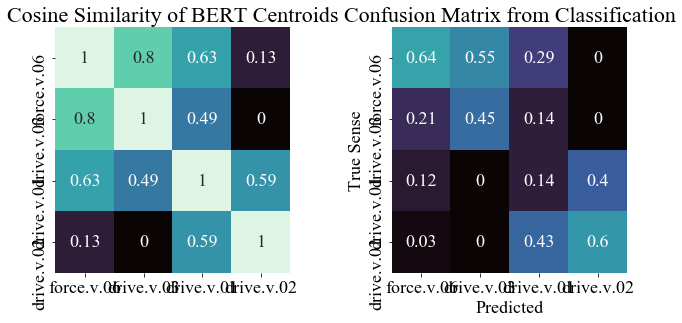

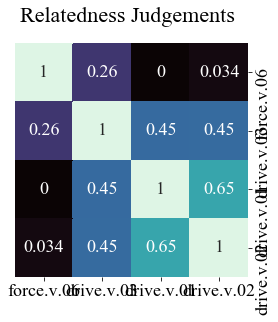

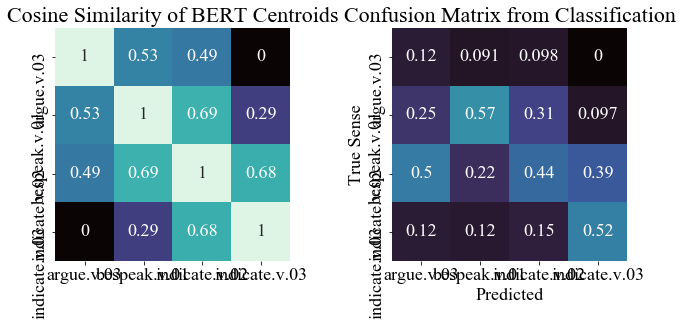

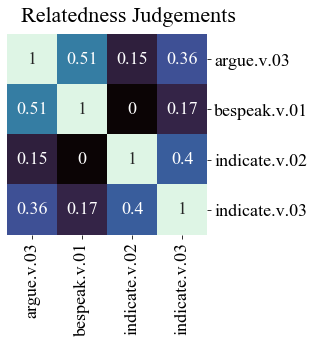

In [38]:
plt.rcParams["font.family"] = "Times New Roman"

confusion_matrices = {w: {} for w in with_entropy['word']}
title_size = 22
text_size = 18

for w in with_entropy['word']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9.5, 4.6))

    avg_reported = get_test_result_data(results, w, incl_users)
    senses = np.array([fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))])
    cg = sns.clustermap(mtx_to_df(1 - avg_reported, senses), cmap = 'mako', annot = True, figsize = (4.6, 4.6),
                        
                           cbar_pos = None, vmin = 0, vmax = 1, annot_kws={"size": text_size})
    cg.fig.suptitle('Relatedness Judgements', y = 0.9, x = 0.55, fontsize = title_size)
    cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = text_size)
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_ymajorticklabels(), fontsize = text_size)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    reordered_sense_indices = cg.dendrogram_row.reordered_ind

    word, pos = w.split("_")
    
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = senses,
                                         corpus = 'semcor', use_masc = False)
    bert_cs = normalize_cos_dist(bert_cs)
    bcs_fig = sns.heatmap(mtx_to_df(1 - bert_cs, senses, reorder = reordered_sense_indices),
                          ax = ax1, annot = True, cmap = 'mako', cbar = False,  vmin = 0, vmax = 1,
                          annot_kws={"size": text_size})
    bcs_fig.set_title("Cosine Similarity of BERT Centroids", fontsize = title_size)
    bcs_fig.set_xticklabels(bcs_fig.get_xmajorticklabels(), fontsize = text_size)
    bcs_fig.set_yticklabels(bcs_fig.get_ymajorticklabels(), fontsize = text_size)

    word_matrices = model_data[w]['confusion_matrices']
    agg_confusion = np.sum(np.asarray(word_matrices), axis = 0)
    agg_confusion = np.nan_to_num(agg_confusion / np.sum(agg_confusion, axis = 0))
    confusion_matrices[w] = agg_confusion.tolist()
    conf_fig = sns.heatmap(mtx_to_df(agg_confusion, senses, reorder = reordered_sense_indices),
                           cmap = 'mako', ax = ax2, annot = True, cbar = False,  vmin = 0, vmax = 1,
                          annot_kws={"size": text_size})
    conf_fig.set_title("Confusion Matrix from Classification", fontsize = title_size)
    conf_fig.set_xticklabels(conf_fig.get_xmajorticklabels(), fontsize = text_size)
    conf_fig.set_yticklabels(conf_fig.get_ymajorticklabels(), fontsize = text_size)

    ax2.set_xlabel("Predicted", fontsize = text_size)
    ax2.set_ylabel("True Sense", fontsize = text_size)
    fig.tight_layout()



Writing the confusion matrices to disk

In [39]:
with open('../data/test_confusion_matrices.json', 'w') as f:
    f.write(json.dumps(confusion_matrices))

## Saving values with nonzero weights

In [19]:
from core.semcor_bert_pipeline import save_embeds_with_wts

In [20]:
for w in model_data.keys():
    results = model_data[w]
    save_embeds_with_wts(results['data'], results['labels'], results['weights'], w.replace('_', '.'))

door.n Proportion of Weights that are Nonzero 0.17578125
time.n Proportion of Weights that are Nonzero 0.6419270833333334
case.n Proportion of Weights that are Nonzero 0.16536458333333334
world.n Proportion of Weights that are Nonzero 0.1875
consider.v Proportion of Weights that are Nonzero 0.2981770833333333
indicate.v Proportion of Weights that are Nonzero 0.23046875
area.n Proportion of Weights that are Nonzero 0.24869791666666666
heart.n Proportion of Weights that are Nonzero 0.078125
face.n Proportion of Weights that are Nonzero 0.18489583333333334
life.n Proportion of Weights that are Nonzero 0.2734375
light.n Proportion of Weights that are Nonzero 0.08984375
put.v Proportion of Weights that are Nonzero 0.3255208333333333
ask.v Proportion of Weights that are Nonzero 0.53125
begin.v Proportion of Weights that are Nonzero 0.4674479166666667
death.n Proportion of Weights that are Nonzero 0.13411458333333334
man.n Proportion of Weights that are Nonzero 0.7369791666666666
cover.v Prop